In [53]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

print("Path to dataset files:", path)

Path to dataset files: /Users/zack/.cache/kagglehub/datasets/philiphyde1/nfl-stats-1999-2022/versions/15


In [54]:
import pandas as pd
import os

# List files in the dataset directory
files = os.listdir(path)
print("Available files:", files)

# Load the weekly player offense stats - this likely has position data
weekly_offense_df = pd.read_csv(os.path.join(path, 'weekly_player_stats_offense.csv'))
print(f"\nLoaded weekly offense: {len(weekly_offense_df)} records")
print(f"Columns: {list(weekly_offense_df.columns)}")
weekly_offense_df = weekly_offense_df[weekly_offense_df['season'] >= 2024]
weekly_offense_df.head()

Available files: ['yearly_player_stats_defense.csv', 'yearly_team_stats_defense.csv', 'weekly_team_stats_offense.csv', 'weekly_player_stats_offense.csv', 'yearly_team_stats_offense.csv', 'yearly_player_stats_offense.csv', 'weekly_team_stats_defense.csv', 'weekly_player_stats_defense.csv']

Loaded weekly offense: 58629 records
Columns: ['season', 'week', 'offense_snaps', 'offense_pct', 'team_offense_snaps', 'player_id', 'birth_year', 'draft_year', 'draft_round', 'draft_pick', 'draft_ovr', 'height', 'weight', 'college', 'season_type', 'player_name', 'position', 'depth_team', 'conference', 'division', 'team', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble', 'pass_attempts', 'complete_pass', 'incomplete_pass', 'passing_yards', 'receiving_yards', 'yards_after_catch', 'rush_attempts', 'rushing_yards', 'tackled_for_loss', 'first_down_pass', 'first_down_rush', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'rush_touchdown', 'pass_touchdown', 's

,season,week,offense_snaps,offense_pct,team_offense_snaps,player_id,birth_year,draft_year,draft_round,draft_pick,...,career_rush_td_pct,career_ypc,career_td_pct,career_yptouch,career_pass_ypg,career_rec_ypg,career_rush_ypg,career_ypg,career_average_ppr_ppg,career_average_standard_ppg
53682,2024,1,38.0,0.75,51.0,00-0023459,1983,2005.0,1.0,24.0,...,0.043,4.75,0.06,7.36,255.56,-0.07,13.81,1.68,23.68,23.66
53683,2024,2,57.0,1.00,57.0,00-0023459,1983,2005.0,1.0,24.0,...,0.043,4.73,0.06,7.35,255.06,-0.07,13.73,1.67,23.65,23.63
53684,2024,3,73.0,1.00,73.0,00-0023459,1983,2005.0,1.0,24.0,...,0.043,4.74,0.06,7.35,255.22,-0.07,13.76,1.66,23.66,23.64
53685,2024,4,74.0,1.00,74.0,00-0023459,1983,2005.0,1.0,24.0,...,0.042,4.75,0.06,7.33,255.04,-0.07,13.83,1.65,23.58,23.57
53686,2024,5,72.0,1.00,72.0,00-0023459,1983,2005.0,1.0,24.0,...,0.042,4.75,0.06,7.31,254.97,-0.07,13.75,1.64,23.54,23.52


In [55]:
# Check if ADP data is in the columns
adp_columns = [col for col in weekly_offense_df.columns if 'adp' in col.lower()]
print("ADP related columns:", adp_columns)

# Also check for draft-related columns beyond the basic ones we saw
draft_columns = [col for col in weekly_offense_df.columns if 'draft' in col.lower()]
print("Draft related columns:", draft_columns)

# Look at a sample of the data to see what we have
print("\nSample data for a known player:")
sample_player = weekly_offense_df[weekly_offense_df['player_name'] == 'Josh Allen'].head(3)
print(sample_player[['player_name', 'position', 'week', 'fantasy_points_ppr', 'draft_year', 'draft_round', 'draft_pick']].to_string())

ADP related columns: []
Draft related columns: ['draft_year', 'draft_round', 'draft_pick', 'draft_ovr']

Sample data for a known player:
      player_name position  week  fantasy_points_ppr  draft_year  draft_round  draft_pick
55093  Josh Allen       QB     1               34.18      2018.0          1.0         7.0
55094  Josh Allen       QB     2               11.76      2018.0          1.0         7.0
55095  Josh Allen       QB     3               38.92      2018.0          1.0         7.0


In [56]:
# Scrape ADP data from FantasyPros - get all attributes
import requests
from bs4 import BeautifulSoup
import time

def scrape_fantasypros_adp():
    """Scrape ADP data from FantasyPros PPR rankings with all attributes"""
    
    url = "https://www.fantasypros.com/nfl/adp/ppr-overall.php"
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    print(f"Scraping {url}...")
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the ADP table
        table = soup.find('table', {'class': 'player-table'}) or soup.find('table')
        
        if table:
            # First, get the header row to understand column structure
            header_row = table.find('tr')
            if header_row:
                headers = [th.get_text().strip() for th in header_row.find_all(['th', 'td'])]
                print(f"Table columns found: {headers}")
            
            adp_data = []
            rows = table.find_all('tr')[1:]  # Skip header
            
            for row in rows:
                cols = row.find_all(['td', 'th'])
                
                if len(cols) >= 4:  # Make sure we have enough columns
                    try:
                        row_data = {}
                        
                        # Extract all column data
                        for i, col in enumerate(cols):
                            col_text = col.get_text().strip()
                            
                            # Try to match columns to common ADP table structure
                            if i == 0 and col_text.isdigit():
                                row_data['rank'] = int(col_text)
                            elif i == 1:  # Player column
                                # Parse player info - could be "Name (TEAM - POS)" or similar
                                if '(' in col_text and ')' in col_text:
                                    name_part = col_text.split('(')[0].strip()
                                    meta_part = col_text.split('(')[1].split(')')[0]
                                    
                                    row_data['player_name'] = name_part
                                    
                                    # Parse team and position from meta part
                                    if ' - ' in meta_part:
                                        team, position = meta_part.split(' - ', 1)
                                        row_data['team'] = team.strip()
                                        row_data['position'] = position.strip()
                                    else:
                                        row_data['team'] = meta_part
                                        row_data['position'] = ''
                                else:
                                    row_data['player_name'] = col_text
                            elif 'bye' in (headers[i] if i < len(headers) else '').lower():
                                row_data['bye_week'] = col_text
                            elif any(word in (headers[i] if i < len(headers) else '').lower() for word in ['adp', 'avg']):
                                try:
                                    row_data['adp'] = float(col_text)
                                except:
                                    pass
                            elif 'best' in (headers[i] if i < len(headers) else '').lower():
                                row_data['best_pick'] = col_text
                            elif 'worst' in (headers[i] if i < len(headers) else '').lower():
                                row_data['worst_pick'] = col_text
                            elif '+/-' in (headers[i] if i < len(headers) else '') or 'change' in (headers[i] if i < len(headers) else '').lower():
                                row_data['adp_change'] = col_text
                            else:
                                # Store all other columns with their header names
                                if i < len(headers) and headers[i]:
                                    row_data[headers[i].lower().replace(' ', '_')] = col_text
                        
                        # Only add if we have essential data
                        if 'player_name' in row_data and row_data['player_name']:
                            adp_data.append(row_data)
                            
                    except Exception as e:
                        print(f"Error parsing row: {e}")
                        continue
            
            if adp_data:
                adp_df = pd.DataFrame(adp_data)
                print(f"✓ Scraped {len(adp_df)} players with ADP data")
                print(f"Columns captured: {list(adp_df.columns)}")
                return adp_df
            else:
                print("❌ No ADP data found")
                return None
        else:
            print("❌ Could not find ADP table")
            # Print page content to debug
            print("Page content preview:")
            print(soup.get_text()[:500])
            return None
    else:
        print(f"❌ Failed to fetch page: {response.status_code}")
        return None

# Scrape the ADP data
adp_df = scrape_fantasypros_adp()

if adp_df is not None:
    print(f"\nADP data preview:")
    print(adp_df.head(10))
    print(f"\nAll columns: {list(adp_df.columns)}")
else:
    print("Failed to scrape ADP data")

Scraping https://www.fantasypros.com/nfl/adp/ppr-overall.php...
Table columns found: ['Rank', 'Player Team (Bye)', 'POS', 'ESPN', 'Sleeper', 'NFL', 'RTSports', 'FFC', 'Fantrax', 'AVG']
✓ Scraped 938 players with ADP data
Columns captured: ['rank', 'player_name', 'team', 'position', 'pos', 'espn', 'sleeper', 'nfl', 'rtsports', 'ffc', 'fantrax', 'adp']

ADP data preview:
   rank             player_name team position  pos espn sleeper nfl rtsports  \
0     1       Ja'Marr Chase CIN   10           WR1    1       1   1        1   
1     2      Bijan Robinson ATL    5           RB1    2       3   4        2   
2     3      Saquon Barkley PHI    9           RB2    3       2   2        4   
3     4    Justin Jefferson MIN    6           WR2    4       4   5        6   
4     5        Jahmyr Gibbs DET    8           RB3    5       5   6        3   
5     6         CeeDee Lamb DAL   10           WR3    6       6   3        5   
6     7          Puka Nacua LAR    8           WR4    8       7   7 

In [57]:
# Step 1: Merge Kaggle NFL stats with ADP data
print("=== MERGING NFL STATS WITH ADP DATA ===")

# First, let's clean up player names for better matching
def clean_player_name(name):
    """Clean player names for better matching"""
    if pd.isna(name):
        return ""
    # Remove extra spaces, handle common variations
    name = str(name).strip()
    # Handle Jr., Sr., III variations
    name = name.replace(" Jr.", "").replace(" Sr.", "").replace(" III", "").replace(" II", "")
    return name

# Clean player names in both datasets
weekly_offense_df['player_name_clean'] = weekly_offense_df['player_name'].apply(clean_player_name)

if adp_df is not None:
    adp_df['player_name_clean'] = adp_df['player_name'].apply(clean_player_name)
    
    print(f"ADP columns available: {list(adp_df.columns)}")
    
    # Only merge columns that actually exist
    adp_columns_to_merge = ['player_name_clean']
    for col in ['adp', 'rank', 'bye_week', 'best_pick', 'worst_pick', 'adp_change']:
        if col in adp_df.columns:
            adp_columns_to_merge.append(col)
    
    print(f"Merging columns: {adp_columns_to_merge}")
    
    # Merge the datasets
    merged_df = weekly_offense_df.merge(
        adp_df[adp_columns_to_merge], 
        on='player_name_clean', 
        how='left'
    )
    
    print(f"✓ Merged dataset shape: {merged_df.shape}")
    print(f"✓ Players with ADP data: {merged_df['adp'].notna().sum() if 'adp' in merged_df.columns else 0}/{len(merged_df['player_name'].unique())} unique players")
    
    # Check merge quality
    if 'adp' in merged_df.columns:
        adp_coverage = merged_df['adp'].notna().sum() / len(merged_df)
        print(f"✓ ADP coverage: {adp_coverage:.1%} of all game records")
    
else:
    merged_df = weekly_offense_df.copy()
    print("❌ No ADP data available - using NFL stats only")

merged_df.head()

=== MERGING NFL STATS WITH ADP DATA ===
ADP columns available: ['rank', 'player_name', 'team', 'position', 'pos', 'espn', 'sleeper', 'nfl', 'rtsports', 'ffc', 'fantrax', 'adp', 'player_name_clean']
Merging columns: ['player_name_clean', 'adp', 'rank']
✓ Merged dataset shape: (4947, 384)
✓ Players with ADP data: 129/490 unique players
✓ ADP coverage: 2.6% of all game records


,season,week,offense_snaps,offense_pct,team_offense_snaps,player_id,birth_year,draft_year,draft_round,draft_pick,...,career_yptouch,career_pass_ypg,career_rec_ypg,career_rush_ypg,career_ypg,career_average_ppr_ppg,career_average_standard_ppg,player_name_clean,adp,rank
0,2024,1,38.0,0.75,51.0,00-0023459,1983,2005.0,1.0,24.0,...,7.36,255.56,-0.07,13.81,1.68,23.68,23.66,Aaron Rodgers,NaN,NaN
1,2024,2,57.0,1.00,57.0,00-0023459,1983,2005.0,1.0,24.0,...,7.35,255.06,-0.07,13.73,1.67,23.65,23.63,Aaron Rodgers,NaN,NaN
2,2024,3,73.0,1.00,73.0,00-0023459,1983,2005.0,1.0,24.0,...,7.35,255.22,-0.07,13.76,1.66,23.66,23.64,Aaron Rodgers,NaN,NaN
3,2024,4,74.0,1.00,74.0,00-0023459,1983,2005.0,1.0,24.0,...,7.33,255.04,-0.07,13.83,1.65,23.58,23.57,Aaron Rodgers,NaN,NaN
4,2024,5,72.0,1.00,72.0,00-0023459,1983,2005.0,1.0,24.0,...,7.31,254.97,-0.07,13.75,1.64,23.54,23.52,Aaron Rodgers,NaN,NaN


In [58]:
# Step 2: Data Exploration and Quality Check
print("=== DATA EXPLORATION ===")

# Basic dataset info
print(f"Dataset shape: {merged_df.shape}")
print(f"Unique players: {merged_df['player_name'].nunique()}")
print(f"Unique seasons: {merged_df['season'].unique()}")
print(f"Position breakdown:")
print(merged_df['position'].value_counts())

# ADP coverage by position (if ADP data exists)
if 'adp' in merged_df.columns:
    print(f"\nADP coverage by position:")
    adp_by_pos = merged_df.groupby('position')['adp'].count().sort_values(ascending=False)
    print(adp_by_pos)
    
    print(f"\nTop 20 ADP players:")
    top_adp = merged_df[merged_df['adp'].notna()].groupby(['player_name', 'position']).agg({
        'adp': 'first',
        'season_fantasy_points_ppr': 'last'  # Latest season total
    }).sort_values('adp').head(20)
    print(top_adp)

# Check data completeness for key features
key_features = ['fantasy_points_ppr', 'touches', 'targets', 'passing_yards', 'rushing_yards', 'receiving_yards']
print(f"\nData completeness for key features:")
for feature in key_features:
    if feature in merged_df.columns:
        pct_filled = (merged_df[feature].notna().sum() / len(merged_df)) * 100
        print(f"{feature}: {pct_filled:.1f}% complete")

merged_df.info()

=== DATA EXPLORATION ===
Dataset shape: (4947, 384)
Unique players: 490
Unique seasons: [2024]
Position breakdown:
position
WR     1931
RB     1247
TE     1025
QB      667
FB       53
P         7
CB        6
SS        5
FS        2
OLB       1
DE        1
DT        1
MLB       1
Name: count, dtype: int64

ADP coverage by position:
position
WR     60
RB     52
TE     15
QB      2
CB      0
DE      0
DT      0
FB      0
FS      0
MLB     0
OLB     0
P       0
SS      0
Name: adp, dtype: int64

Top 20 ADP players:
                                  adp  season_fantasy_points_ppr
player_name           position                                  
Zack Moss             RB        273.8                      80.90
Gabe Davis            WR        288.0                      49.60
Ezekiel Elliott       RB        290.0                      51.30
Amari Cooper          WR        290.7                       7.30
Odell Beckham         WR        326.0                      14.50
Carson Wentz          QB    

In [59]:
# Step 3: Feature Engineering - Trajectory Features
print("=== FEATURE ENGINEERING ===")
import numpy as np

def create_trajectory_features(df):
    """Create trajectory and trend features for fantasy prediction"""
    
    # Sort by player and week for proper time series
    df = df.sort_values(['player_name', 'season', 'week']).copy()
    
    # Rolling averages (last 3, 5 games)
    for window in [3, 5]:
        df[f'fantasy_ppr_roll_{window}'] = df.groupby('player_name')['fantasy_points_ppr'].rolling(window, min_periods=1).mean().values
        df[f'touches_roll_{window}'] = df.groupby('player_name')['touches'].rolling(window, min_periods=1).mean().values
        df[f'targets_roll_{window}'] = df.groupby('player_name')['targets'].rolling(window, min_periods=1).mean().values
    
    # Trends (is player improving or declining?)
    df['fantasy_trend_3game'] = df.groupby('player_name')['fantasy_points_ppr'].rolling(3).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0).values
    
    # Usage share trends
    df['snap_share'] = df['offense_snaps'] / df['team_offense_snaps']
    df['snap_share_roll_3'] = df.groupby('player_name')['snap_share'].rolling(3, min_periods=1).mean().values
    
    # Position-specific features
    def position_features(group):
        pos = group['position'].iloc[0]
        
        if pos == 'QB':
            group['pass_att_trend'] = group['pass_attempts'].rolling(3).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0)
            group['rush_att_trend'] = group['rush_attempts'].rolling(3).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0)
        
        elif pos in ['RB', 'FB']:
            group['rush_share'] = group['rush_attempts'] / (group['rush_attempts'] + group['targets'])
            group['goal_line_share'] = group['rush_attempts_gtg'] / (group['rush_attempts_gtg'] + 1)  # Avoid division by 0
            
        elif pos in ['WR', 'TE']:
            group['target_share'] = group['targets'] / (group['targets'].rolling(3).mean() + 1)
            group['air_yards_trend'] = group['receiving_air_yards'].rolling(3).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0)
        
        return group
    
    # Apply position-specific features
    df = df.groupby('player_name').apply(position_features).reset_index(drop=True)
    
    # Age/Experience factors
    df['age_season_start'] = df['age'] - (df['week'] / 17)  # Approximate age at season start
    df['prime_age'] = ((df['age_season_start'] >= 24) & (df['age_season_start'] <= 29)).astype(int)
    
    # Consistency metrics
    df['fantasy_cv'] = df.groupby('player_name')['fantasy_points_ppr'].rolling(5).std().values / df.groupby('player_name')['fantasy_points_ppr'].rolling(5).mean().values
    
    return df

# Apply feature engineering
print("Creating trajectory features...")
merged_df = create_trajectory_features(merged_df)

print(f"✓ Added trajectory features")
print(f"New dataset shape: {merged_df.shape}")

# Show sample of new features
trajectory_features = [col for col in merged_df.columns if any(word in col for word in ['roll', 'trend', 'share', 'cv'])]
print(f"Trajectory features created: {len(trajectory_features)}")
print(trajectory_features[:10])  # Show first 10

merged_df[['player_name', 'position', 'week', 'fantasy_points_ppr'] + trajectory_features[:5]].head()

=== FEATURE ENGINEERING ===
Creating trajectory features...
✓ Added trajectory features
New dataset shape: (4947, 402)
Trajectory features created: 16
['fantasy_ppr_roll_3', 'touches_roll_3', 'targets_roll_3', 'fantasy_ppr_roll_5', 'touches_roll_5', 'targets_roll_5', 'fantasy_trend_3game', 'snap_share', 'snap_share_roll_3', 'target_share']


/var/folders/vy/6_615tw15wqbrqfm1sf_8qsw0000gn/T/ipykernel_38978/572720813.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('player_name').apply(position_features).reset_index(drop=True)


,player_name,position,week,fantasy_points_ppr,fantasy_ppr_roll_3,touches_roll_3,targets_roll_3,fantasy_ppr_roll_5,touches_roll_5
0,A.J. Barner,TE,3,4.3,4.300000,3.000000,3.000000,4.300000,3.00
1,A.J. Barner,TE,4,10.7,7.500000,2.500000,2.500000,7.500000,2.50
2,A.J. Barner,TE,5,2.3,5.766667,2.000000,2.000000,5.766667,2.00
3,A.J. Barner,TE,6,2.3,5.100000,1.333333,1.333333,4.900000,1.75
4,A.J. Barner,TE,7,1.5,2.033333,1.000000,1.000000,4.220000,1.60


In [60]:
import sklearn

# Step 4: Build Position-Specific Prediction Models
print("=== BUILDING POSITION-SPECIFIC MODELS ===")

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def build_position_model(df, position, target='fantasy_points_ppr'):
    """Build prediction model for specific position"""
    
    # Filter to position
    pos_data = df[df['position'] == position].copy()
    
    if len(pos_data) < 100:  # Need minimum data
        print(f"⚠️  Insufficient data for {position}: {len(pos_data)} records")
        return None, None
    
    # Select features based on position
    base_features = ['age', 'week', 'snap_share', 'fantasy_ppr_roll_3', 'fantasy_ppr_roll_5', 
                    'touches_roll_3', 'touches_roll_5', 'fantasy_trend_3game', 'prime_age', 'seasons_played']
    
    if position == 'QB':
        position_features = ['pass_attempts', 'complete_pass', 'passing_yards', 'rush_attempts', 
                           'pass_att_trend', 'rush_att_trend', 'qb_dropback', 'season_pass_attempts']
    elif position in ['RB', 'FB']:
        position_features = ['rush_attempts', 'rushing_yards', 'receptions', 'receiving_yards',
                           'rush_share', 'goal_line_share', 'rush_attempts_redzone', 'season_rush_attempts']
    elif position in ['WR', 'TE']:
        position_features = ['targets', 'receptions', 'receiving_yards', 'receiving_air_yards',
                           'target_share', 'air_yards_trend', 'targets_redzone', 'season_targets']
    else:
        position_features = []
    
    # Combine all features
    all_features = base_features + position_features
    
    # Only keep features that exist in the dataset
    available_features = [f for f in all_features if f in pos_data.columns]
    
    # Remove rows with missing target or features
    model_data = pos_data[available_features + [target]].dropna()
    
    if len(model_data) < 50:
        print(f"⚠️  Insufficient clean data for {position}: {len(model_data)} records")
        return None, None
    
    print(f"✓ Building {position} model with {len(model_data)} records and {len(available_features)} features")
    
    # Prepare data
    X = model_data[available_features]
    y = model_data[target]
    
    # Split data (use recent games for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build ensemble model
    model = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"  - MAE: {mae:.2f}")
    print(f"  - R²: {r2:.3f}")
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': available_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"  - Top 5 features: {', '.join(importance.head()['feature'].tolist())}")
    
    return model, available_features

# Build models for main fantasy positions
models = {}
feature_sets = {}

for position in ['QB', 'RB', 'WR', 'TE']:
    print(f"\\nBuilding model for {position}:")
    model, features = build_position_model(merged_df, position)
    if model is not None:
        models[position] = model
        feature_sets[position] = features

print(f"\\n✓ Successfully built {len(models)} position models")

=== BUILDING POSITION-SPECIFIC MODELS ===
\nBuilding model for QB:
✓ Building QB model with 524 records and 18 features
  - MAE: 3.00
  - R²: 0.885
  - Top 5 features: fantasy_ppr_roll_3, fantasy_trend_3game, passing_yards, pass_att_trend, fantasy_ppr_roll_5
\nBuilding model for RB:
✓ Building RB model with 1041 records and 18 features
  - MAE: 1.42
  - R²: 0.934
  - Top 5 features: rushing_yards, fantasy_ppr_roll_3, fantasy_trend_3game, receiving_yards, receptions
\nBuilding model for WR:
✓ Building WR model with 1583 records and 18 features
  - MAE: 1.59
  - R²: 0.918
  - Top 5 features: receiving_yards, receptions, fantasy_trend_3game, fantasy_ppr_roll_3, targets_redzone
\nBuilding model for TE:
✓ Building TE model with 828 records and 18 features
  - MAE: 1.06
  - R²: 0.916
  - Top 5 features: receiving_yards, fantasy_trend_3game, receptions, fantasy_ppr_roll_3, targets_redzone
\n✓ Successfully built 4 position models


In [61]:
# Step 5: Generate 2025 Projections and Value Scores
print("=== GENERATING 2025 PROJECTIONS ===")

def predict_2025_performance(df, models, feature_sets):
    """Generate 2025 season projections for players"""
    
    # Get latest player stats (end of 2024 season)
    latest_stats = df[df['season'] == 2024].groupby('player_name').last().reset_index()
    
    projections = []
    
    for _, player in latest_stats.iterrows():
        position = player['position']
        
        if position in models:
            model = models[position]
            features = feature_sets[position]
            
            # Create feature vector for prediction
            feature_data = {}
            for feature in features:
                if feature in player and pd.notna(player[feature]):
                    feature_data[feature] = player[feature]
                else:
                    # Fill missing values with reasonable defaults
                    if 'roll' in feature:
                        feature_data[feature] = 0  # Rolling averages
                    elif 'trend' in feature:
                        feature_data[feature] = 0  # Trends
                    elif 'share' in feature:
                        feature_data[feature] = 0.5  # Shares
                    elif feature == 'age':
                        feature_data[feature] = 26  # Average age
                    elif feature == 'week':
                        feature_data[feature] = 9  # Mid-season
                    elif feature == 'prime_age':
                        feature_data[feature] = 1
                    elif feature == 'seasons_played':
                        feature_data[feature] = 3
                    else:
                        feature_data[feature] = 0  # Default to 0 for other features
            
            try:
                # Predict season total (17 games)
                X_pred = pd.DataFrame([feature_data])
                
                # Fill any remaining NaNs
                X_pred = X_pred.fillna(0)
                
                weekly_pred = model.predict(X_pred)[0]
                season_pred = weekly_pred * 17  # Project to full season
                
                # Apply some adjustments
                # Age regression for older players
                if player['age'] > 30:
                    age_factor = max(0.85, 1 - (player['age'] - 30) * 0.03)
                    season_pred *= age_factor
                
                # Rookie/sophomore boost potential
                if player['seasons_played'] <= 2 and player['age'] < 25:
                    season_pred *= 1.1
                
                projections.append({
                    'player_name': player['player_name'],
                    'position': position,
                    'team': player['team'],
                    'age': player['age'],
                    'adp': player.get('adp', None),
                    'projected_ppr': max(0, season_pred),  # No negative projections
                    'last_season_ppr': player.get('season_fantasy_points_ppr', 0),
                    'trajectory_trend': player.get('fantasy_trend_3game', 0),
                    'snap_share': player.get('snap_share', 0)
                })
            except Exception as e:
                print(f"Error predicting for {player['player_name']}: {e}")
                continue
    
    return pd.DataFrame(projections)

# Generate projections
projections_df = predict_2025_performance(merged_df, models, feature_sets)

# Calculate value scores (projected points per ADP)
projections_df['value_score'] = projections_df['projected_ppr'] / (projections_df['adp'].fillna(999) + 1)  # +1 to avoid division by 0
projections_df['adp_vs_projection'] = projections_df['projected_ppr'] - (200 - projections_df['adp'].fillna(150) * 10)  # Rough ADP to points conversion

print(f"✓ Generated projections for {len(projections_df)} players")
projections_df.head(10)

=== GENERATING 2025 PROJECTIONS ===
✓ Generated projections for 463 players


,player_name,position,team,age,adp,projected_ppr,last_season_ppr,trajectory_trend,snap_share,value_score,adp_vs_projection
0,A.J. Barner,TE,SEA,22,NaN,269.931826,76.50,6.45,0.563636,0.269932,1569.931826
1,A.J. Brown,WR,PHI,27,NaN,199.077504,36.30,3.95,0.878378,0.199078,1499.077504
2,Aaron Jones,RB,MIN,30,NaN,212.285014,236.60,0.10,0.615385,0.212285,1512.285014
3,Aaron Rodgers,QB,NYJ,41,NaN,476.959702,306.58,9.56,1.000000,0.476960,1776.959702
4,Adam Thielen,WR,CAR,34,NaN,188.817184,22.90,3.55,0.310811,0.188817,1488.817184
5,Adam Trautman,TE,DEN,27,NaN,25.467916,43.80,-4.25,0.483333,0.025468,1325.467916
6,Adonai Mitchell,WR,IND,22,NaN,2.611272,52.76,-2.30,0.210526,0.002611,1302.611272
7,Aidan O'Connell,QB,LV,26,NaN,338.660796,84.88,4.19,0.941176,0.338661,1638.660796
8,Ainias Smith,WR,PHI,23,NaN,200.041687,13.90,NaN,0.691176,0.200042,1500.041687
9,Alec Pierce,WR,IND,24,NaN,303.466808,153.40,7.85,0.820513,0.303467,1603.466808


In [62]:
# Step 6: Interpret Results and Rankings
print("=== MODEL INTERPRETATION & PLAYER RANKINGS ===")

# First, let's see what our models actually learned
print("🧠 MODEL INSIGHTS:")
for position in models.keys():
    print(f"\n{position} Model:")
    features = feature_sets[position]
    model = models[position]
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"  Top 5 predictors: {', '.join(importance_df.head()['feature'].tolist())}")
    
    # What drives fantasy performance for this position?
    top_features = importance_df.head(3)
    for _, row in top_features.iterrows():
        print(f"    - {row['feature']}: {row['importance']:.3f}")

print(f"\n📊 PROJECTION QUALITY CHECK:")
if len(projections_df) > 0:
    print(f"Players projected: {len(projections_df)}")
    print(f"With ADP data: {projections_df['adp'].notna().sum()}")
    
    # Distribution of projections by position
    print(f"\nProjections by position:")
    pos_summary = projections_df.groupby('position').agg({
        'projected_ppr': ['count', 'mean', 'std', 'min', 'max']
    }).round(1)
    print(pos_summary)
    
    # Show top projections vs ADP
    print(f"\n🔝 HIGHEST PROJECTED PLAYERS (All Positions):")
    top_projected = projections_df.nlargest(15, 'projected_ppr')
    for _, player in top_projected.iterrows():
        adp_str = f"ADP {player['adp']:.0f}" if pd.notna(player['adp']) else "Undrafted"
        print(f"  {player['player_name']} ({player['position']}) - {player['projected_ppr']:.0f} pts, {adp_str}")
    
    # Position-specific rankings
    print(f"\n📈 POSITION RANKINGS:")
    for position in ['QB', 'RB', 'WR', 'TE']:
        pos_players = projections_df[projections_df['position'] == position].sort_values('projected_ppr', ascending=False)
        
        if len(pos_players) > 0:
            print(f"\n{position} Rankings (Top 12):")
            for i, (_, player) in enumerate(pos_players.head(12).iterrows(), 1):
                adp_str = f"ADP {player['adp']:.0f}" if pd.notna(player['adp']) else "Undrafted"
                trend_str = f"📈 +{player['trajectory_trend']:.1f}" if player['trajectory_trend'] > 0 else f"📉 {player['trajectory_trend']:.1f}" if player['trajectory_trend'] < 0 else "➡️ Flat"
                print(f"  {i:2d}. {player['player_name']:20} - {player['projected_ppr']:3.0f} pts, {adp_str:12} {trend_str}")

else:
    print("No projections generated - check model building step")

print(f"\n🎯 Ready to analyze specific players or build draft strategy?")

=== MODEL INTERPRETATION & PLAYER RANKINGS ===
🧠 MODEL INSIGHTS:

QB Model:
  Top 5 predictors: fantasy_ppr_roll_3, fantasy_trend_3game, passing_yards, pass_att_trend, fantasy_ppr_roll_5
    - fantasy_ppr_roll_3: 0.469
    - fantasy_trend_3game: 0.291
    - passing_yards: 0.163

RB Model:
  Top 5 predictors: rushing_yards, fantasy_ppr_roll_3, fantasy_trend_3game, receiving_yards, receptions
    - rushing_yards: 0.338
    - fantasy_ppr_roll_3: 0.275
    - fantasy_trend_3game: 0.213

WR Model:
  Top 5 predictors: receiving_yards, receptions, fantasy_trend_3game, fantasy_ppr_roll_3, targets_redzone
    - receiving_yards: 0.746
    - receptions: 0.077
    - fantasy_trend_3game: 0.076

TE Model:
  Top 5 predictors: receiving_yards, fantasy_trend_3game, receptions, fantasy_ppr_roll_3, targets_redzone
    - receiving_yards: 0.691
    - fantasy_trend_3game: 0.105
    - receptions: 0.086

📊 PROJECTION QUALITY CHECK:
Players projected: 463
With ADP data: 13

Projections by position:
         pro

In [63]:
# Setup plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("husl")

Matplotlib is building the font cache; this may take a moment.


In [64]:
# Create comprehensive analysis dataset
print("=== BUILDING COMPREHENSIVE ANALYSIS DATASET ===")

# Calculate additional metrics for analysis
analysis_df = projections_df.copy()

# Add delta calculations (projected vs last season)
analysis_df['ppr_delta'] = analysis_df['projected_ppr'] - analysis_df['last_season_ppr'] 
analysis_df['ppr_delta_pct'] = (analysis_df['ppr_delta'] / (analysis_df['last_season_ppr'] + 1)) * 100

# Add ranking within position
for position in ['QB', 'RB', 'WR', 'TE']:
    pos_mask = analysis_df['position'] == position
    analysis_df.loc[pos_mask, 'projected_rank'] = analysis_df.loc[pos_mask, 'projected_ppr'].rank(ascending=False, method='min')
    if 'adp' in analysis_df.columns:
        analysis_df.loc[pos_mask, 'adp_rank'] = analysis_df.loc[pos_mask, 'adp'].rank(ascending=True, method='min')

# Value metrics
if 'adp' in analysis_df.columns:
    analysis_df['value_score'] = analysis_df['projected_ppr'] / (analysis_df['adp'] + 1)
    analysis_df['adp_delta'] = analysis_df['adp_rank'] - analysis_df['projected_rank']  # Positive = overvalued
    analysis_df['draft_value'] = analysis_df['adp_delta']  # Rename for clarity

# Age categories
analysis_df['age_category'] = pd.cut(analysis_df['age'], 
                                   bins=[0, 24, 27, 30, 40], 
                                   labels=['Young', 'Prime', 'Veteran', 'Aging'])

# Performance categories
analysis_df['proj_category'] = pd.cut(analysis_df['projected_ppr'], 
                                    bins=[0, 100, 150, 200, 400], 
                                    labels=['Low', 'Mid', 'High', 'Elite'])

print(f"✓ Enhanced dataset with {len(analysis_df)} players and {len(analysis_df.columns)} metrics")
analysis_df.head()

=== BUILDING COMPREHENSIVE ANALYSIS DATASET ===
✓ Enhanced dataset with 463 players and 19 metrics


,player_name,position,team,age,adp,projected_ppr,last_season_ppr,trajectory_trend,snap_share,value_score,adp_vs_projection,ppr_delta,ppr_delta_pct,projected_rank,adp_rank,adp_delta,draft_value,age_category,proj_category
0,A.J. Barner,TE,SEA,22,NaN,269.931826,76.50,6.45,0.563636,NaN,1569.931826,193.431826,249.589453,10.0,NaN,NaN,NaN,Young,Elite
1,A.J. Brown,WR,PHI,27,NaN,199.077504,36.30,3.95,0.878378,NaN,1499.077504,162.777504,436.400816,42.0,NaN,NaN,NaN,Prime,High
2,Aaron Jones,RB,MIN,30,NaN,212.285014,236.60,0.10,0.615385,NaN,1512.285014,-24.314986,-10.233580,23.0,NaN,NaN,NaN,Veteran,Elite
3,Aaron Rodgers,QB,NYJ,41,NaN,476.959702,306.58,9.56,1.000000,NaN,1776.959702,170.379702,55.393622,10.0,NaN,NaN,NaN,NaN,NaN
4,Adam Thielen,WR,CAR,34,NaN,188.817184,22.90,3.55,0.310811,NaN,1488.817184,165.917184,694.214158,46.0,NaN,NaN,NaN,Aging,High


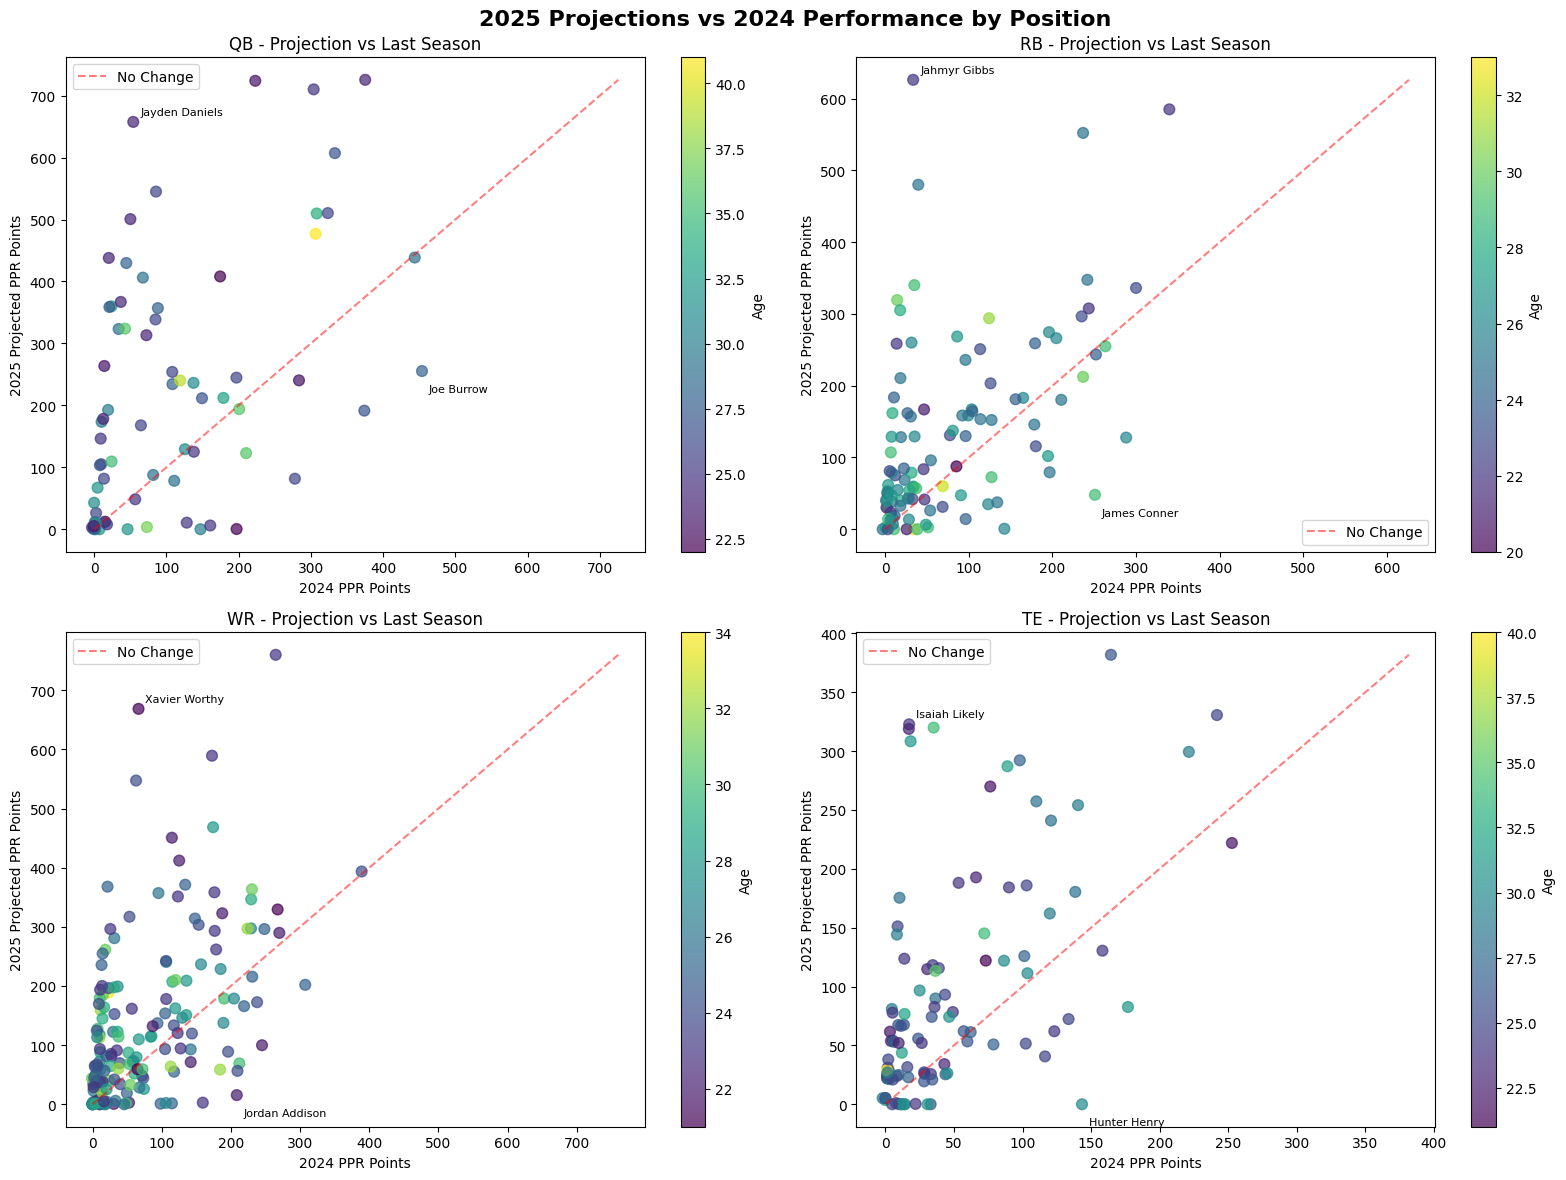

📈 Scatter plots show projected vs actual performance - points above red line = projected improvement


In [65]:
# Visualization 1: Projected vs Last Season Performance by Position
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('2025 Projections vs 2024 Performance by Position', fontsize=16, fontweight='bold')

positions = ['QB', 'RB', 'WR', 'TE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, position in enumerate(positions):
    ax = axes[i//2, i%2]
    pos_data = analysis_df[analysis_df['position'] == position]
    
    # Scatter plot
    scatter = ax.scatter(pos_data['last_season_ppr'], pos_data['projected_ppr'], 
                        c=pos_data['age'], cmap='viridis', alpha=0.7, s=60)
    
    # Add diagonal line (no change)
    max_val = max(pos_data['projected_ppr'].max(), pos_data['last_season_ppr'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='No Change')
    
    ax.set_xlabel('2024 PPR Points')
    ax.set_ylabel('2025 Projected PPR Points') 
    ax.set_title(f'{position} - Projection vs Last Season')
    ax.legend()
    
    # Color bar for age
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Age')
    
    # Add annotations for extreme movers
    if len(pos_data) > 0:
        # Biggest gainers
        biggest_gainer = pos_data.loc[pos_data['ppr_delta'].idxmax()]
        ax.annotate(biggest_gainer['player_name'], 
                   (biggest_gainer['last_season_ppr'], biggest_gainer['projected_ppr']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # Biggest decliners  
        biggest_decliner = pos_data.loc[pos_data['ppr_delta'].idxmin()]
        ax.annotate(biggest_decliner['player_name'],
                   (biggest_decliner['last_season_ppr'], biggest_decliner['projected_ppr']), 
                   xytext=(5, -15), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("📈 Scatter plots show projected vs actual performance - points above red line = projected improvement")

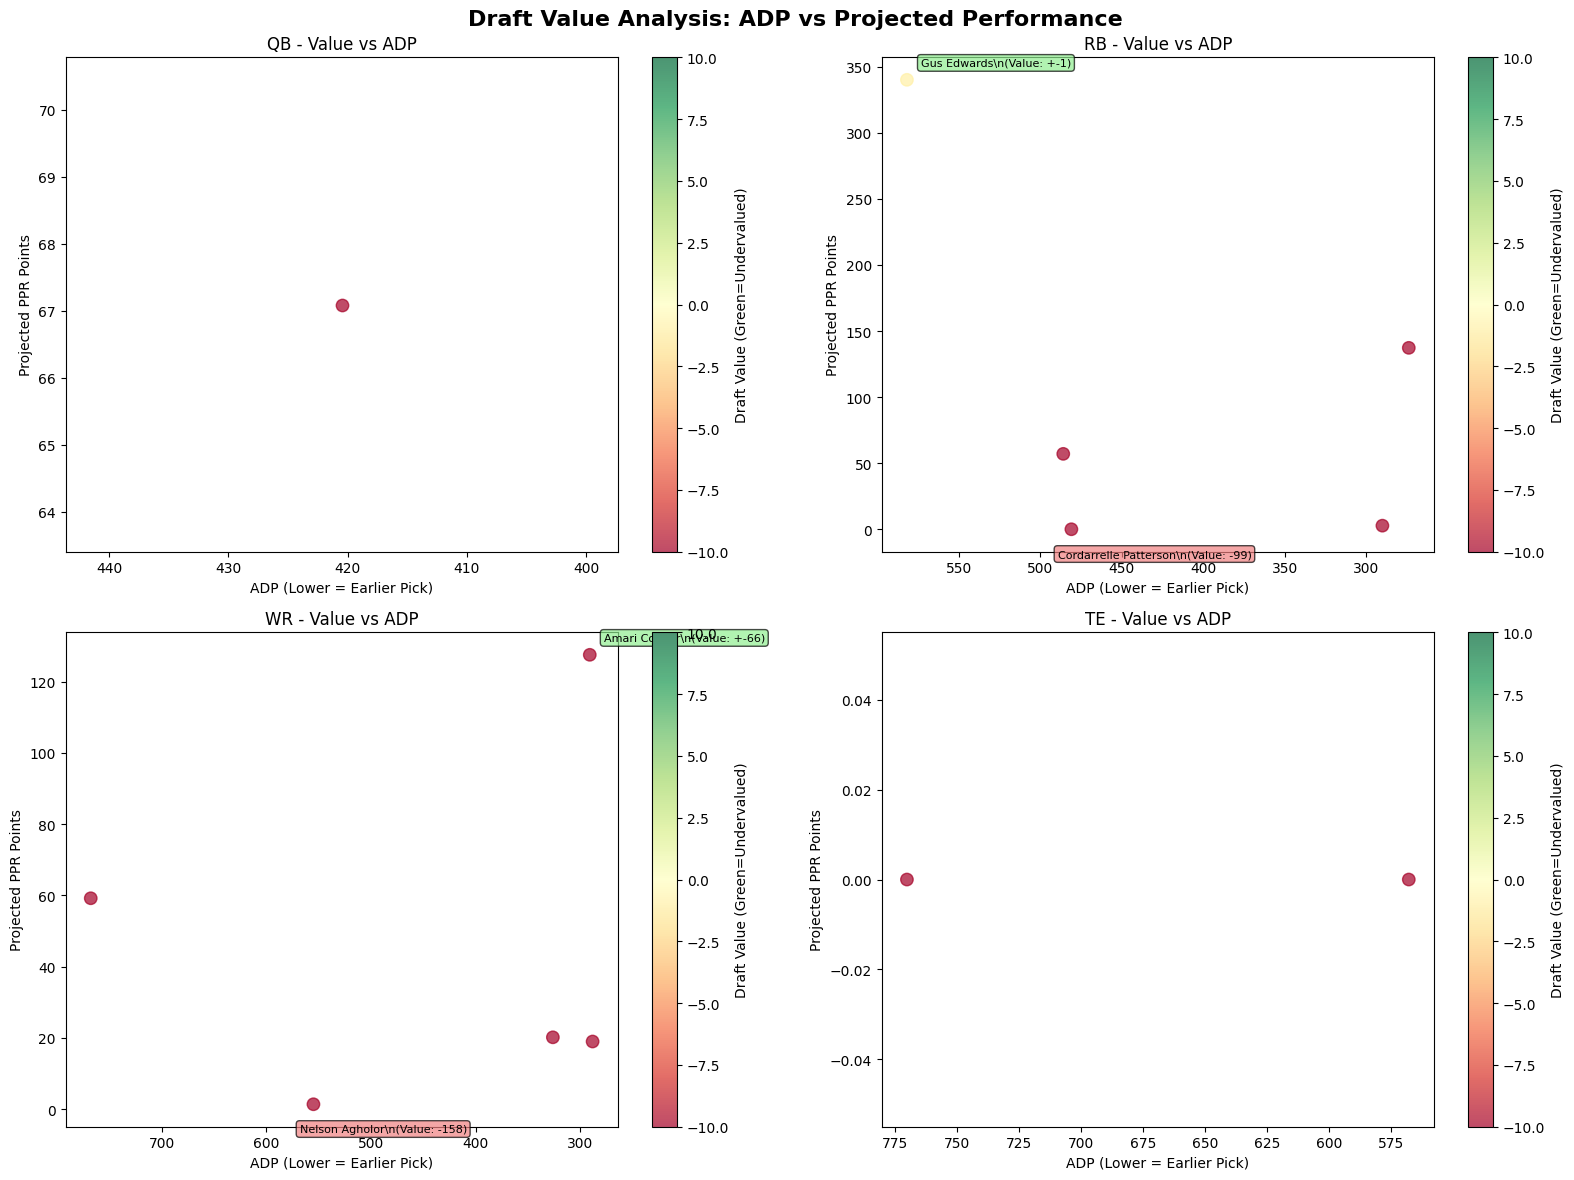

🎯 Green dots = undervalued (projected better than ADP), Red dots = overvalued (ADP too high)


In [66]:
# Visualization 2: ADP vs Projection Value Chart
if 'adp' in analysis_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Draft Value Analysis: ADP vs Projected Performance', fontsize=16, fontweight='bold')
    
    for i, position in enumerate(positions):
        ax = axes[i//2, i%2]
        pos_data = analysis_df[(analysis_df['position'] == position) & (analysis_df['adp'].notna())]
        
        if len(pos_data) > 0:
            # Color by draft value (positive = undervalued, negative = overvalued)
            scatter = ax.scatter(pos_data['adp'], pos_data['projected_ppr'], 
                               c=pos_data['draft_value'], cmap='RdYlGn', alpha=0.7, s=80,
                               vmin=-10, vmax=10)
            
            ax.set_xlabel('ADP (Lower = Earlier Pick)')
            ax.set_ylabel('Projected PPR Points')
            ax.set_title(f'{position} - Value vs ADP')
            ax.invert_xaxis()  # Lower ADP (earlier picks) on left
            
            # Color bar
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Draft Value (Green=Undervalued)')
            
            # Annotate extreme values
            if len(pos_data) >= 5:
                # Best values (undervalued)
                best_value = pos_data.loc[pos_data['draft_value'].idxmax()]
                ax.annotate(f"{best_value['player_name']}\\n(Value: +{best_value['draft_value']:.0f})", 
                           (best_value['adp'], best_value['projected_ppr']),
                           xytext=(10, 10), textcoords='offset points', fontsize=8,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
                
                # Worst values (overvalued)  
                worst_value = pos_data.loc[pos_data['draft_value'].idxmin()]
                ax.annotate(f"{worst_value['player_name']}\\n(Value: {worst_value['draft_value']:.0f})",
                           (worst_value['adp'], worst_value['projected_ppr']),
                           xytext=(-10, -20), textcoords='offset points', fontsize=8,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    print("🎯 Green dots = undervalued (projected better than ADP), Red dots = overvalued (ADP too high)")
else:
    print("⚠️ No ADP data available for value analysis")

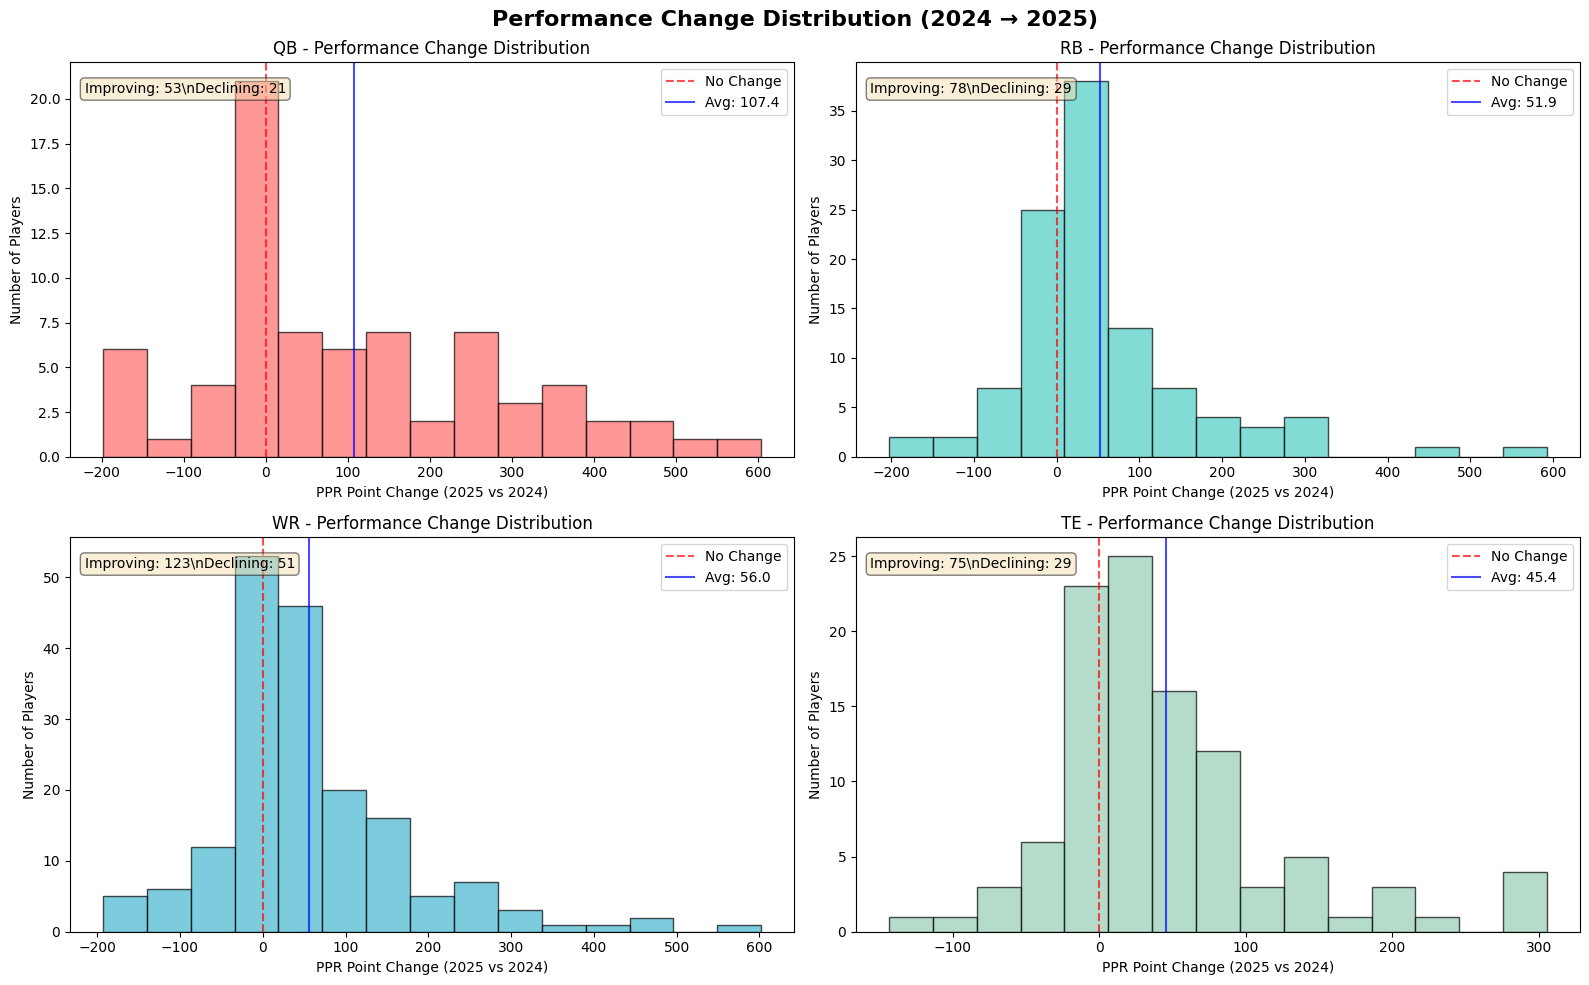

📊 Histograms show how many players are projected to improve vs decline at each position


In [67]:
# Visualization 3: Performance Delta Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Performance Change Distribution (2024 → 2025)', fontsize=16, fontweight='bold')

for i, position in enumerate(positions):
    ax = axes[i//2, i%2]
    pos_data = analysis_df[analysis_df['position'] == position]
    
    if len(pos_data) > 0:
        # Histogram of performance deltas
        ax.hist(pos_data['ppr_delta'], bins=15, alpha=0.7, color=colors[i], edgecolor='black')
        
        # Add vertical line at zero (no change)
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No Change')
        
        # Add mean line
        mean_delta = pos_data['ppr_delta'].mean()
        ax.axvline(x=mean_delta, color='blue', linestyle='-', alpha=0.7, label=f'Avg: {mean_delta:.1f}')
        
        ax.set_xlabel('PPR Point Change (2025 vs 2024)')
        ax.set_ylabel('Number of Players')
        ax.set_title(f'{position} - Performance Change Distribution')
        ax.legend()
        
        # Add summary stats
        improving = (pos_data['ppr_delta'] > 0).sum()
        declining = (pos_data['ppr_delta'] < 0).sum()
        ax.text(0.02, 0.95, f'Improving: {improving}\\nDeclining: {declining}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()
print("📊 Histograms show how many players are projected to improve vs decline at each position")

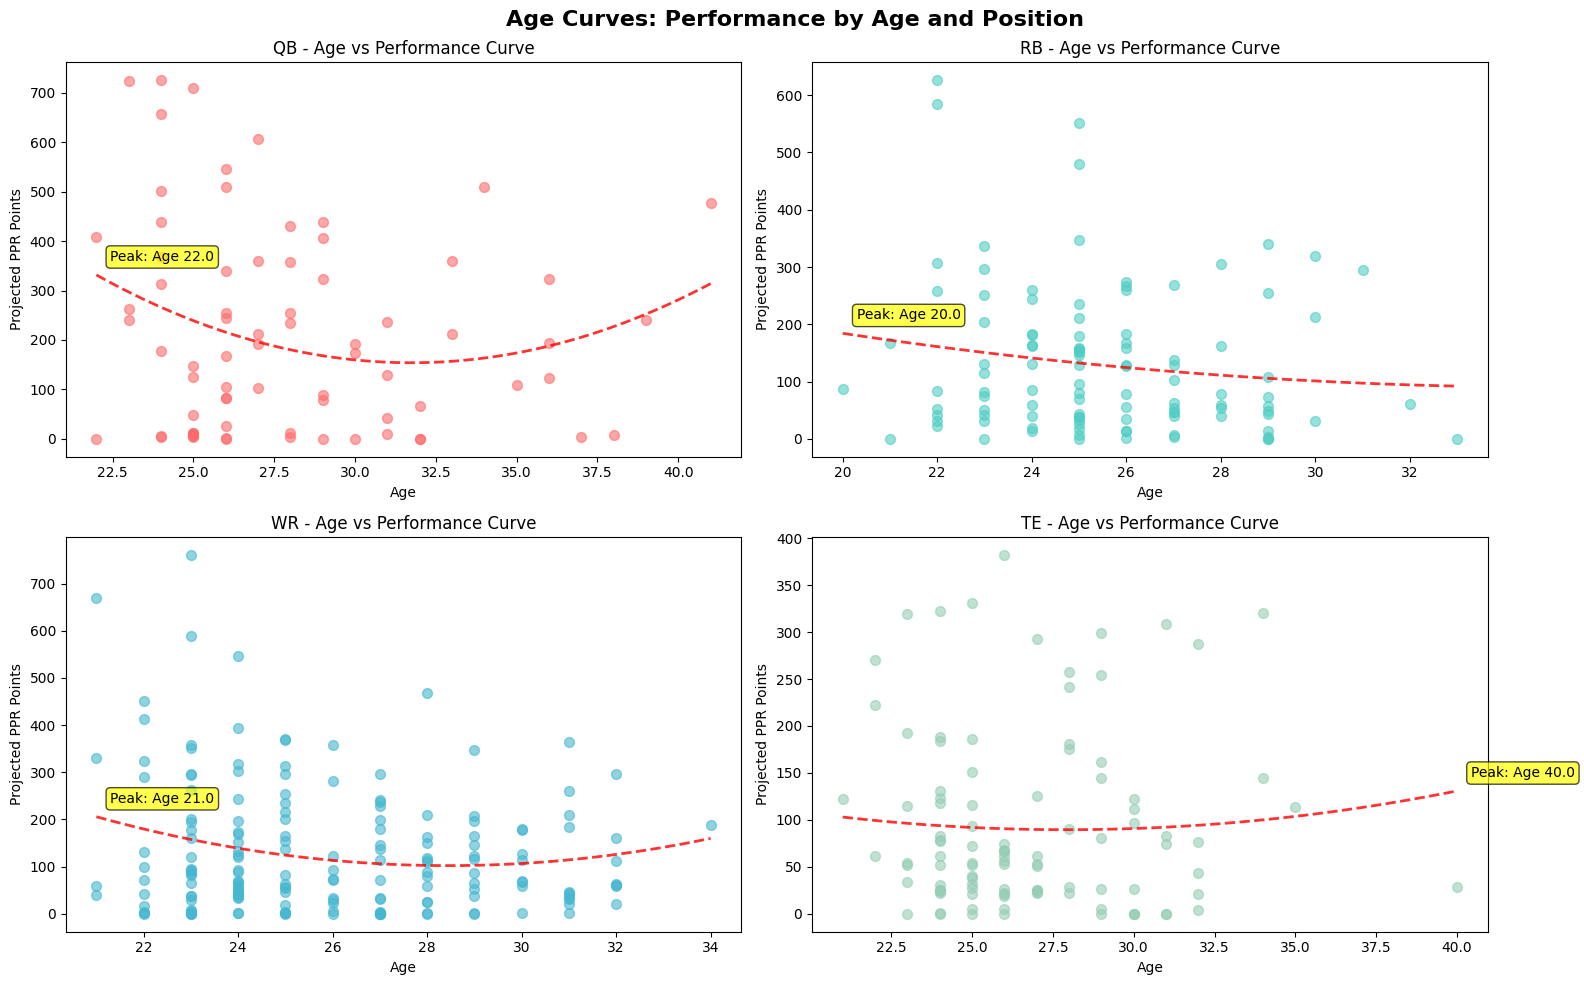

📈 Red curves show optimal age ranges for each position


In [68]:
# Visualization 4: Age vs Performance Curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Age Curves: Performance by Age and Position', fontsize=16, fontweight='bold')

for i, position in enumerate(positions):
    ax = axes[i//2, i%2]
    pos_data = analysis_df[analysis_df['position'] == position]
    
    if len(pos_data) > 0:
        # Scatter plot with trend line
        ax.scatter(pos_data['age'], pos_data['projected_ppr'], alpha=0.6, color=colors[i], s=50)
        
        # Add trend line
        z = np.polyfit(pos_data['age'], pos_data['projected_ppr'], 2)  # Quadratic fit
        p = np.poly1d(z)
        age_range = np.linspace(pos_data['age'].min(), pos_data['age'].max(), 100)
        ax.plot(age_range, p(age_range), "r--", alpha=0.8, linewidth=2)
        
        ax.set_xlabel('Age')
        ax.set_ylabel('Projected PPR Points')
        ax.set_title(f'{position} - Age vs Performance Curve')
        
        # Highlight peak age
        peak_age = age_range[np.argmax(p(age_range))]
        peak_performance = np.max(p(age_range))
        ax.annotate(f'Peak: Age {peak_age:.1f}', 
                   xy=(peak_age, peak_performance), 
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()
print("📈 Red curves show optimal age ranges for each position")

In [69]:
# Generate detailed CSV exports for each position
print("=== GENERATING POSITION-SPECIFIC CSV EXPORTS ===")

# Define columns for export
base_columns = ['player_name', 'team', 'age', 'position']
performance_columns = ['projected_ppr', 'last_season_ppr', 'ppr_delta', 'ppr_delta_pct']
ranking_columns = ['projected_rank', 'adp_rank', 'draft_value'] if 'adp' in analysis_df.columns else ['projected_rank']
trajectory_columns = ['trajectory_trend', 'snap_share']
if 'adp' in analysis_df.columns:
    adp_columns = ['adp', 'value_score']
else:
    adp_columns = []

export_columns = base_columns + performance_columns + ranking_columns + trajectory_columns + adp_columns

# Export each position
for position in ['QB', 'RB', 'WR', 'TE']:
    pos_data = analysis_df[analysis_df['position'] == position].copy()
    
    if len(pos_data) > 0:
        # Sort by projected performance
        pos_data = pos_data.sort_values('projected_ppr', ascending=False)
        
        # Select and rename columns for clarity
        export_data = pos_data[export_columns].copy()
        export_data = export_data.round(2)
        
        # Export to CSV
        filename = f'{position.lower()}_analysis_2025.csv'
        export_data.to_csv(filename, index=False)
        print(f"✓ Exported {len(export_data)} {position}s to {filename}")
        
        # Show preview
        print(f"\\n{position} Top 5 Preview:")
        print(export_data.head()[['player_name', 'projected_ppr', 'ppr_delta', 'adp' if 'adp' in export_data.columns else 'projected_rank']].to_string(index=False))

# Also create a master file with all positions
all_data = analysis_df[export_columns].copy()
all_data = all_data.sort_values(['position', 'projected_ppr'], ascending=[True, False])
all_data = all_data.round(2)
all_data.to_csv('fantasy_analysis_2025_master.csv', index=False)
print(f"\\n✅ Master file exported: fantasy_analysis_2025_master.csv ({len(all_data)} total players)")

print("\\n📁 Files ready for analysis in Excel/Google Sheets!")

=== GENERATING POSITION-SPECIFIC CSV EXPORTS ===
✓ Exported 74 QBs to qb_analysis_2025.csv
\nQB Top 5 Preview:
   player_name  projected_ppr  ppr_delta  adp
        Bo Nix         725.54     350.34  NaN
   Bryce Young         723.92     500.90  NaN
   Brock Purdy         710.11     406.25  NaN
Jayden Daniels         657.57     603.51  NaN
  Kyler Murray         607.15     273.91  NaN
✓ Exported 107 RBs to rb_analysis_2025.csv
\nRB Top 5 Preview:
    player_name  projected_ppr  ppr_delta  adp
   Jahmyr Gibbs         626.13     592.63  NaN
 Bijan Robinson         584.96     245.26  NaN
  Chuba Hubbard         552.17     315.57  NaN
     James Cook         479.95     440.35  NaN
Jonathan Taylor         347.54     105.84  NaN
✓ Exported 178 WRs to wr_analysis_2025.csv
\nWR Top 5 Preview:
     player_name  projected_ppr  ppr_delta  adp
    Drake London         759.95     495.15  NaN
   Xavier Worthy         668.56     602.06  NaN
Quentin Johnston         589.33     416.63  NaN
     Rashee R

In [70]:
# Quick Summary Tables for Review
print("=== QUICK REFERENCE TABLES ===")

# Top regression candidates (biggest declines)
print("\\n📉 BIGGEST REGRESSION CANDIDATES:")
regression_candidates = analysis_df[analysis_df['ppr_delta'] < -20].sort_values('ppr_delta').head(10)
if len(regression_candidates) > 0:
    for _, player in regression_candidates.iterrows():
        adp_str = f"ADP {player['adp']:.0f}" if pd.notna(player['adp']) else "Undrafted" 
        print(f"  {player['player_name']:20} ({player['position']}) - {player['ppr_delta']:.0f} pts decline, {adp_str}")
else:
    print("  No major regression candidates identified")

# Top breakout candidates (biggest improvements)
print("\\n🚀 BIGGEST BREAKOUT CANDIDATES:")
breakout_candidates = analysis_df[analysis_df['ppr_delta'] > 20].sort_values('ppr_delta', ascending=False).head(10)
if len(breakout_candidates) > 0:
    for _, player in breakout_candidates.iterrows():
        adp_str = f"ADP {player['adp']:.0f}" if pd.notna(player['adp']) else "Undrafted"
        print(f"  {player['player_name']:20} ({player['position']}) - +{player['ppr_delta']:.0f} pts improvement, {adp_str}")
else:
    print("  No major breakout candidates identified")

# Best draft values (if ADP available)
if 'draft_value' in analysis_df.columns:
    print("\\n💎 BEST DRAFT VALUES (Undervalued by ADP):")
    best_values = analysis_df[(analysis_df['adp'].notna()) & (analysis_df['draft_value'] > 3)].sort_values('draft_value', ascending=False).head(10)
    if len(best_values) > 0:
        for _, player in best_values.iterrows():
            print(f"  {player['player_name']:20} ({player['position']}) - {player['projected_ppr']:.0f} proj pts, ADP {player['adp']:.0f} (Value: +{player['draft_value']:.0f})")
    else:
        print("  No significant draft values identified")
        
    print("\\n⚠️  DRAFT TRAPS (Overvalued by ADP):")
    draft_traps = analysis_df[(analysis_df['adp'].notna()) & (analysis_df['draft_value'] < -3)].sort_values('draft_value').head(10)  
    if len(draft_traps) > 0:
        for _, player in draft_traps.iterrows():
            print(f"  {player['player_name']:20} ({player['position']}) - {player['projected_ppr']:.0f} proj pts, ADP {player['adp']:.0f} (Overvalued by {abs(player['draft_value']):.0f})")
    else:
        print("  No major draft traps identified")

# Age-based insights
print("\\n👴 AGING VETERANS (Age 30+, High Projection):")
aging_vets = analysis_df[(analysis_df['age'] >= 30) & (analysis_df['projected_ppr'] > 150)].sort_values('projected_ppr', ascending=False).head(8)
for _, player in aging_vets.iterrows():
    trend_str = f"+{player['trajectory_trend']:.1f}" if player['trajectory_trend'] > 0 else f"{player['trajectory_trend']:.1f}"
    print(f"  {player['player_name']:20} ({player['position']}) - Age {player['age']}, {player['projected_ppr']:.0f} pts, Trend: {trend_str}")

print("\\n🌟 YOUNG STUDS (Age <26, Elite Projection):")  
young_studs = analysis_df[(analysis_df['age'] < 26) & (analysis_df['projected_ppr'] > 180)].sort_values('projected_ppr', ascending=False).head(8)
for _, player in young_studs.iterrows():
    trend_str = f"+{player['trajectory_trend']:.1f}" if player['trajectory_trend'] > 0 else f"{player['trajectory_trend']:.1f}"
    print(f"  {player['player_name']:20} ({player['position']}) - Age {player['age']}, {player['projected_ppr']:.0f} pts, Trend: {trend_str}")

=== QUICK REFERENCE TABLES ===
\n📉 BIGGEST REGRESSION CANDIDATES:
  James Conner         (RB) - -203 pts decline, Undrafted
  Joe Burrow           (QB) - -198 pts decline, Undrafted
  Drake Maye           (QB) - -197 pts decline, Undrafted
  Jordan Love          (QB) - -196 pts decline, Undrafted
  Jordan Addison       (WR) - -193 pts decline, Undrafted
  Sam Darnold          (QB) - -183 pts decline, Undrafted
  Josh Jacobs          (RB) - -160 pts decline, Undrafted
  George Pickens       (WR) - -157 pts decline, Undrafted
  Trevor Lawrence      (QB) - -155 pts decline, Undrafted
  Zay Flowers          (WR) - -153 pts decline, Undrafted
\n🚀 BIGGEST BREAKOUT CANDIDATES:
  Jayden Daniels       (QB) - +604 pts improvement, Undrafted
  Xavier Worthy        (WR) - +602 pts improvement, Undrafted
  Jahmyr Gibbs         (RB) - +593 pts improvement, Undrafted
  Bryce Young          (QB) - +501 pts improvement, Undrafted
  Drake London         (WR) - +495 pts improvement, Undrafted
  Rashee Ri